In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model

import io
from google.colab import drive, files

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
shared_project_base_dir = 'My Drive/CS486 Project Data' #@param {type:"string"}
full_project_dir = f"/content/drive/{shared_project_base_dir}"

In [4]:
np.random.seed(1)

# Simple CNN Structure



In [5]:
# Model Parameters
num_filters = 32 
kernel_size = (3, 3)
pool_size = (2, 2)
dense1_units = 256
dense2_units = 128
output_units = 7

# Training Parameters
epochs = 16
batch_size = 64
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]

In [6]:
class simpleCNN:
  def __init__(self, num_layers, num_filters, kernel_size, pool_size, dense1_units, dense2_units, output_units):
    self.model = models.Sequential()
    self.model.add(Conv2D(num_filters, kernel_size, activation='relu', input_shape=(48, 48, 1)))
    self.model.add(AveragePooling2D(pool_size))
    for i in range(num_layers-1):
      self.model.add(Conv2D(num_filters, kernel_size, activation='relu'))
      self.model.add(MaxPool2D(pool_size))
    self.model.add(Flatten())
    self.model.add(Dense(dense1_units, activation='relu'))
    self.model.add(Dense(dense2_units, activation='relu'))
    self.model.add(Dense(output_units, activation='softmax'))
    self.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  def train(self, train_images, train_labels, val_images, val_labels, class_weight, epochs, batch_size, callbacks):
    history = self.model.fit(train_images, train_labels,
                             validation_data=(val_images, val_labels),
                             class_weight = class_weight,
                             epochs=epochs,
                             batch_size=batch_size,
                             callbacks=callbacks)
    return history

In [7]:
fer_emotions_dict = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

# Using Raw Data

In [4]:
data = pd.read_csv(f"{full_project_dir}/raw_data/fer2013/fer2013.csv")

In [ ]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
data['emotion'].value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [ ]:
def data_prep(data):
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        
    return image_array, image_label

In [ ]:
train_image, train_label = data_prep(data[data['Usage']=='Training'])
val_image, val_label = data_prep(data[data['Usage']=='PrivateTest'])
test_image, test_label = data_prep(data[data['Usage']=='PublicTest'])

In [ ]:
# Reshape and scale the images
train_images = train_image.reshape((train_image.shape[0], 48, 48, 1)).astype('float32')/255
val_images = val_image.reshape((val_image.shape[0], 48, 48, 1)).astype('float32')/255
test_images = test_image.reshape((test_image.shape[0], 48, 48, 1)).astype('float32')/255

In [ ]:
train_labels = to_categorical(train_label)
val_labels = to_categorical(val_label)
test_labels = to_categorical(test_label)

In [ ]:
# Proportion of each emotion in the training set 
class_weight = dict(zip(range(0, 7), (((data[data['Usage']=='Training']['emotion'].value_counts())
                                       .sort_index())/len(data[data['Usage']=='Training']['emotion'])).tolist()))
display(class_weight)

{0: 0.1391549688251071,
 1: 0.01518687519593159,
 2: 0.14270786164617366,
 3: 0.2513149186666202,
 4: 0.16823992476226968,
 5: 0.11045316799609878,
 6: 0.17294228290779895}

## Train Model

In [ ]:
classifier_3layers = simpleCNN(3, num_filters, kernel_size, pool_size, 
                               dense1_units, dense2_units, output_units)

In [ ]:
classifier_3layers.model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 32)        320       
_________________________________________________________________
average_pooling2d (AveragePo (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 21, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 32)          9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0

In [ ]:
history_3layers = classifier_3layers.train(train_images, train_labels, 
                                           val_images, val_labels, 
                                           class_weight, epochs, batch_size,
                                           callbacks)

Epoch 1/16
449/449 [==============================] - 3s 6ms/step - loss: 0.2731 - accuracy: 0.3031 - val_loss: 1.6422 - val_accuracy: 0.3603
Epoch 2/16
449/449 [==============================] - 3s 6ms/step - loss: 0.2378 - accuracy: 0.4025 - val_loss: 1.5655 - val_accuracy: 0.4032
Epoch 3/16
449/449 [==============================] - 3s 6ms/step - loss: 0.2204 - accuracy: 0.4489 - val_loss: 1.4168 - val_accuracy: 0.4609
Epoch 4/16
449/449 [==============================] - 3s 6ms/step - loss: 0.2076 - accuracy: 0.4826 - val_loss: 1.3611 - val_accuracy: 0.4809
Epoch 5/16
449/449 [==============================] - 3s 6ms/step - loss: 0.1966 - accuracy: 0.5140 - val_loss: 1.3371 - val_accuracy: 0.4999
Epoch 6/16
449/449 [==============================] - 3s 6ms/step - loss: 0.1879 - accuracy: 0.5336 - val_loss: 1.3285 - val_accuracy: 0.5091
Epoch 7/16
449/449 [==============================] - 3s 6ms/step - loss: 0.1789 - accuracy: 0.5570 - val_loss: 1.2912 - val_accuracy: 0.5199
Epoch 

## Evaluate Model

In [ ]:
test_loss, test_accuracy = classifier_3layers.model.evaluate(test_images, test_labels)
print('Test Accuracy:', test_accuracy)

113/113 [==============================] - 0s 3ms/step - loss: 1.6100 - accuracy: 0.5283
Test Accuracy: 0.5282808542251587


In [ ]:
classifier_3layers.model.save(f"{full_project_dir}/models/simple_CNN_3layers_raw_data")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/My Drive/CS486 Project Data/models/simple_CNN_3layers_raw_data/assets


## Adjusting the Number of Layers

In [ ]:
classifier_2layers = simpleCNN(2, num_filters, kernel_size, pool_size,
                               dense1_units, dense2_units, output_units)

classifier_4layers = simpleCNN(4, num_filters, kernel_size, pool_size,
                               dense1_units, dense2_units, output_units)

In [ ]:
classifier_2layers.model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 46, 46, 32)        320       
_________________________________________________________________
average_pooling2d_1 (Average (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 21, 21, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               819456    
_________________________________________________________________
dense_4 (Dense)              (None, 128)              

In [ ]:
classifier_4layers.model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 46, 46, 32)        320       
_________________________________________________________________
average_pooling2d_2 (Average (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 21, 21, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 32)          9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 2, 2, 32)         

In [ ]:
history_2layers = classifier_2layers.train(train_images, train_labels, val_images, val_labels, class_weight, epochs, batch_size, callbacks)

Epoch 1/16
449/449 [==============================] - 3s 6ms/step - loss: 0.2554 - accuracy: 0.3561 - val_loss: 1.5763 - val_accuracy: 0.3954
Epoch 2/16
449/449 [==============================] - 2s 6ms/step - loss: 0.2199 - accuracy: 0.4540 - val_loss: 1.4051 - val_accuracy: 0.4712
Epoch 3/16
449/449 [==============================] - 2s 5ms/step - loss: 0.2025 - accuracy: 0.5005 - val_loss: 1.3734 - val_accuracy: 0.4882
Epoch 4/16
449/449 [==============================] - 2s 6ms/step - loss: 0.1860 - accuracy: 0.5439 - val_loss: 1.3300 - val_accuracy: 0.4976
Epoch 5/16
449/449 [==============================] - 2s 6ms/step - loss: 0.1691 - accuracy: 0.5871 - val_loss: 1.3176 - val_accuracy: 0.5057
Epoch 6/16
449/449 [==============================] - 2s 6ms/step - loss: 0.1501 - accuracy: 0.6370 - val_loss: 1.3352 - val_accuracy: 0.5235
Epoch 7/16
449/449 [==============================] - 2s 6ms/step - loss: 0.1283 - accuracy: 0.6887 - val_loss: 1.3891 - val_accuracy: 0.5141
Epoch 

In [ ]:
history_4layers = classifier_4layers.train(train_images, train_labels, val_images, val_labels, class_weight, epochs, batch_size, callbacks)

Epoch 1/16
449/449 [==============================] - 3s 6ms/step - loss: 0.2895 - accuracy: 0.2512 - val_loss: 1.8576 - val_accuracy: 0.2449
Epoch 2/16
449/449 [==============================] - 3s 6ms/step - loss: 0.2595 - accuracy: 0.3348 - val_loss: 1.6159 - val_accuracy: 0.3879
Epoch 3/16
449/449 [==============================] - 3s 6ms/step - loss: 0.2330 - accuracy: 0.4116 - val_loss: 1.4959 - val_accuracy: 0.4333
Epoch 4/16
449/449 [==============================] - 3s 6ms/step - loss: 0.2205 - accuracy: 0.4409 - val_loss: 1.4711 - val_accuracy: 0.4313
Epoch 5/16
449/449 [==============================] - 3s 6ms/step - loss: 0.2112 - accuracy: 0.4673 - val_loss: 1.5504 - val_accuracy: 0.4266
Epoch 6/16
449/449 [==============================] - 3s 6ms/step - loss: 0.2042 - accuracy: 0.4893 - val_loss: 1.4134 - val_accuracy: 0.4600
Epoch 7/16
449/449 [==============================] - 3s 6ms/step - loss: 0.1977 - accuracy: 0.5041 - val_loss: 1.3594 - val_accuracy: 0.4848
Epoch 

In [ ]:
test_loss_2layers, test_accuracy_2layers = classifier_2layers.model.evaluate(test_images, test_labels)
print('Test accuracy using 2-layer CNN:', test_accuracy_2layers)

113/113 [==============================] - 0s 3ms/step - loss: 1.9467 - accuracy: 0.5166
Test accuracy using 2-layer CNN: 0.5165784358978271


In [ ]:
test_loss_4layers, test_accuracy_4layers = classifier_4layers.model.evaluate(test_images, test_labels)
print('Test accuracy using 4-layer CNN:', test_accuracy_4layers)

113/113 [==============================] - 0s 3ms/step - loss: 1.3182 - accuracy: 0.5138
Test accuracy using 4-layer CNN: 0.5137921571731567


In [ ]:
classifier_2layers.model.save(f"{full_project_dir}/models/simple_CNN_2layers_raw_data")
classifier_4layers.model.save(f"{full_project_dir}/models/simple_CNN_4layers_raw_data")

INFO:tensorflow:Assets written to: /content/drive/My Drive/CS486 Project Data/models/simple_CNN_2layers_raw_data/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/CS486 Project Data/models/simple_CNN_4layers_raw_data/assets


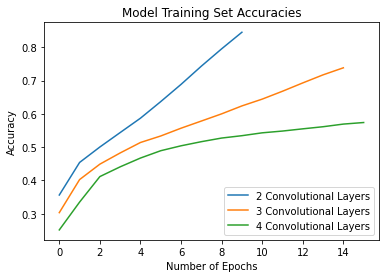

In [ ]:
# Plot training accuracies
plt.plot(history_2layers.history['accuracy'])
plt.plot(history_3layers.history['accuracy'])
plt.plot(history_4layers.history['accuracy'])
plt.title("Model Training Set Accuracies")
plt.ylabel('Accuracy')
plt.xlabel('Number of Epochs')
plt.legend(['2 Convolutional Layers', '3 Convolutional Layers', '4 Convolutional Layers'], loc='lower right')
plt.show()

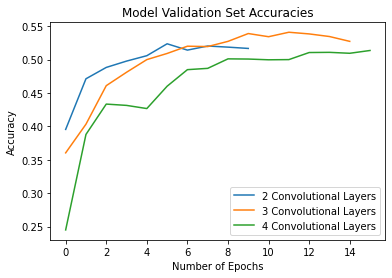

In [ ]:
# Plot validation accuracies
plt.plot(history_2layers.history['val_accuracy'])
plt.plot(history_3layers.history['val_accuracy'])
plt.plot(history_4layers.history['val_accuracy'])
plt.title("Model Validation Set Accuracies")
plt.ylabel('Accuracy')
plt.xlabel('Number of Epochs')
plt.legend(['2 Convolutional Layers', '3 Convolutional Layers', '4 Convolutional Layers'], loc='lower right')
plt.show()

# Using Pre-processed Data

## Helper Functions

In [8]:
def get_emotion_labels(labels):
  emotions = []
  for label in labels:
    max_val = max(label)
    if label[0] == max_val:
      emotions.append('Angry')
    elif label[1] == max_val:
      emotions.append('Disgust')
    elif label[2] == max_val:
      emotions.append('Fear')
    elif label[3] == max_val:
      emotions.append('Happy')
    elif label[4] == max_val:
      emotions.append('Sad')
    elif label[5] == max_val:
      emotions.append('Surprise')
    elif label[6] == max_val:
      emotions.append('Neutral')
  return emotions


In [9]:
def plot_accuracies(history_2layers, history_3layers, history_4layers, num_filters=None, num_units=None):
  if (num_filters and num_units):
    title_specifier = f" - Filters: {str(num_filters)}, Units: {str(num_units)}"
  else:
    title_specifier = ""
  plt.figure(figsize=(12,4))
  plt.tight_layout()
  # Training 
  plt.subplot(1, 2, 1)
  plt.plot(history_2layers.history['accuracy'])
  plt.plot(history_3layers.history['accuracy'])
  plt.plot(history_4layers.history['accuracy'])
  plt.title(f"Training Accuracies{title_specifier}")
  plt.ylabel('Accuracy')
  plt.xlabel('Number of Epochs')
  plt.legend(['2 Convolutional Layers', '3 Convolutional Layers', '4 Convolutional Layers'], loc='lower right')
  # Validation
  plt.subplot(1, 2, 2)
  plt.plot(history_2layers.history['val_accuracy'])
  plt.plot(history_3layers.history['val_accuracy'])
  plt.plot(history_4layers.history['val_accuracy'])
  plt.title(f"Validation Accuracies{title_specifier}")
  plt.ylabel('Accuracy')
  plt.xlabel('Number of Epochs')
  plt.legend(['2 Convolutional Layers', '3 Convolutional Layers', '4 Convolutional Layers'], loc='lower right') 
  plt.show()

## Load Data

In [10]:
train_X = np.load(f"{full_project_dir}/preprocessed_data/fer2013_train_X.npy", allow_pickle=True)
train_Y = np.load(f"{full_project_dir}/preprocessed_data/fer2013_train_Y.npy", allow_pickle=True)
val_X = np.load(f"{full_project_dir}/preprocessed_data/fer2013_val_X.npy", allow_pickle=True)
val_Y = np.load(f"{full_project_dir}/preprocessed_data/fer2013_val_Y.npy", allow_pickle=True)
test_X = np.load(f"{full_project_dir}/preprocessed_data/fer2013_test_X.npy", allow_pickle=True)
test_Y = np.load(f"{full_project_dir}/preprocessed_data/fer2013_test_Y.npy", allow_pickle=True)

In [11]:
train_image = np.stack(train_X)
val_image = np.stack(val_X)
test_image = np.stack(test_X)

In [12]:
train_images_preprocessed = train_image.reshape((train_image.shape[0], 48, 48, 1)).astype('float32')/255
val_images_preprocessed = val_image.reshape((val_image.shape[0], 48, 48, 1)).astype('float32')/255
test_images_preprocessed = test_image.reshape((test_image.shape[0], 48, 48, 1)).astype('float32')/255

In [13]:
labels = get_emotion_labels(train_Y)
np.unique(labels, return_counts=True)

(array(['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise'],
       dtype='<U8'), array([ 7990,   872,  8194, 14430,  9930,  9660,  6342]))

In [14]:
# Proportion of each emotion in the training set 
class_weight = dict(zip([0,1,2,3,6,4,5], ((np.unique(labels, return_counts=True)[1])/len(train_Y)).tolist()))
display(class_weight)

{0: 0.1391549688251071,
 1: 0.01518687519593159,
 2: 0.14270786164617366,
 3: 0.2513149186666202,
 4: 0.16823992476226968,
 5: 0.11045316799609878,
 6: 0.17294228290779895}

## Train Models Using Different Parameters

In [15]:
filters_list = [16, 32, 64]
units_list = [(128, 64), (256, 128), (512, 256)]

In [16]:
results_2layer = pd.DataFrame({f'{units_list[0]}': [0,0,0], f'{units_list[1]}': [0,0,0], f'{units_list[2]}': [0,0,0]},
                              index=[f'{filters_list[0]}', f'{filters_list[1]}', f'{filters_list[2]}'])

results_3layer = pd.DataFrame({f'{units_list[0]}': [0,0,0], f'{units_list[1]}': [0,0,0], f'{units_list[2]}': [0,0,0]},
                              index=[f'{filters_list[0]}', f'{filters_list[1]}', f'{filters_list[2]}'])

results_4layer = pd.DataFrame({f'{units_list[0]}': [0,0,0], f'{units_list[1]}': [0,0,0], f'{units_list[2]}': [0,0,0]},
                              index=[f'{filters_list[0]}', f'{filters_list[1]}', f'{filters_list[2]}'])

In [17]:
def choose_params(train_X, train_Y, val_X, val_Y, test_X, test_Y, 
                  filters_list, units_list,
                  results_2layer, results_3layer, results_4layer):
  highest_test_acc = 0
  best_model = None
  for num_filters in filters_list:
    for num_units in units_list:
      classifier_2layers = simpleCNN(2, num_filters, kernel_size, pool_size,
                                     num_units[0], num_units[1], output_units)
      classifier_3layers = simpleCNN(3, num_filters, kernel_size, pool_size,
                                      num_units[0], num_units[1], output_units)
      classifier_4layers = simpleCNN(4, num_filters, kernel_size, pool_size,
                                      num_units[0], num_units[1], output_units)
      
      print(f"Training 2 layer model - Num Filters: {num_filters}, Num Units: {num_units}")
      history_2layers = classifier_2layers.train(train_X, train_Y, val_X, val_Y, 
                                                 class_weight, epochs, batch_size,
                                                 callbacks)
      print(f"Training 3 layer model - Num Filters: {num_filters}, Num Units: {num_units}")
      history_3layers = classifier_3layers.train(train_X, train_Y, val_X, val_Y, 
                                                 class_weight, epochs, batch_size,
                                                 callbacks)
      print(f"Training 4 layer model - Num Filters: {num_filters}, Num Units: {num_units}")
      history_4layers = classifier_4layers.train(train_X, train_Y, val_X, val_Y, 
                                                 class_weight, epochs, batch_size,
                                                 callbacks)
      
      test_loss_2layers, test_accuracy_2layers = classifier_2layers.model.evaluate(test_X, test_Y)
      test_loss_3layers, test_accuracy_3layers = classifier_3layers.model.evaluate(test_X, test_Y)
      test_loss_4layers, test_accuracy_4layers = classifier_4layers.model.evaluate(test_X, test_Y)

      results_2layer.loc[f'{num_filters}', f'{num_units}'] = test_accuracy_2layers
      results_3layer.loc[f'{num_filters}', f'{num_units}'] = test_accuracy_3layers
      results_4layer.loc[f'{num_filters}', f'{num_units}'] = test_accuracy_4layers

      plot_accuracies(history_2layers, history_3layers, history_4layers, num_filters, num_units)

      best_acc = max(test_accuracy_2layers, test_accuracy_3layers, test_accuracy_4layers)
      if (best_acc > highest_test_acc):
        highest_test_acc = best_acc
        if (best_acc == test_accuracy_2layers):
          best_model = classifier_2layers
        elif (best_acc == test_accuracy_3layers):
          best_model = classifier_3layers
        else: 
          best_model = classifier_4layers

  best_model.model.save(f"{full_project_dir}/models/best_simple_CNN")
  print(best_model.model.summary())
  return best_model, results_2layer, results_3layer, results_4layer

Training 2 layer model - Num Filters: 16, Num Units: (128, 64)
Epoch 1/16
898/898 [==============================] - 4s 4ms/step - loss: 0.2492 - accuracy: 0.3679 - val_loss: 1.4756 - val_accuracy: 0.4333
Epoch 2/16
898/898 [==============================] - 4s 4ms/step - loss: 0.2185 - accuracy: 0.4526 - val_loss: 1.4202 - val_accuracy: 0.4611
Epoch 3/16
898/898 [==============================] - 4s 4ms/step - loss: 0.2042 - accuracy: 0.4910 - val_loss: 1.4005 - val_accuracy: 0.4712
Epoch 4/16
898/898 [==============================] - 4s 4ms/step - loss: 0.1939 - accuracy: 0.5173 - val_loss: 1.4348 - val_accuracy: 0.4812
Epoch 5/16
898/898 [==============================] - 4s 4ms/step - loss: 0.1845 - accuracy: 0.5458 - val_loss: 1.3783 - val_accuracy: 0.4907
Epoch 6/16
898/898 [==============================] - 4s 4ms/step - loss: 0.1750 - accuracy: 0.5679 - val_loss: 1.3334 - val_accuracy: 0.5071
Epoch 7/16
898/898 [==============================] - 4s 4ms/step - loss: 0.1661 - ac

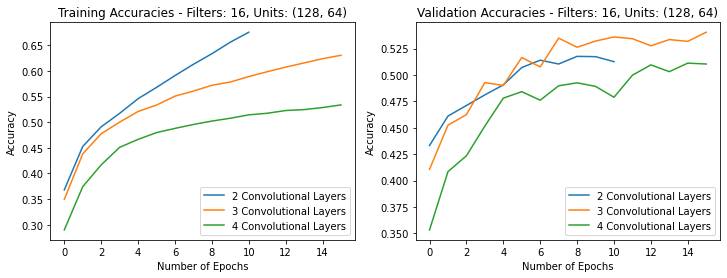

Training 2 layer model - Num Filters: 16, Num Units: (256, 128)
Epoch 1/16
898/898 [==============================] - 4s 4ms/step - loss: 0.2396 - accuracy: 0.3932 - val_loss: 1.4803 - val_accuracy: 0.4425
Epoch 2/16
898/898 [==============================] - 4s 4ms/step - loss: 0.2080 - accuracy: 0.4791 - val_loss: 1.3672 - val_accuracy: 0.4773
Epoch 3/16
898/898 [==============================] - 4s 4ms/step - loss: 0.1915 - accuracy: 0.5242 - val_loss: 1.3083 - val_accuracy: 0.5082
Epoch 4/16
898/898 [==============================] - 4s 4ms/step - loss: 0.1778 - accuracy: 0.5619 - val_loss: 1.2813 - val_accuracy: 0.5191
Epoch 5/16
898/898 [==============================] - 4s 4ms/step - loss: 0.1644 - accuracy: 0.5954 - val_loss: 1.3303 - val_accuracy: 0.5152
Epoch 6/16
898/898 [==============================] - 4s 4ms/step - loss: 0.1509 - accuracy: 0.6293 - val_loss: 1.3506 - val_accuracy: 0.5277
Epoch 7/16
898/898 [==============================] - 4s 4ms/step - loss: 0.1363 - a

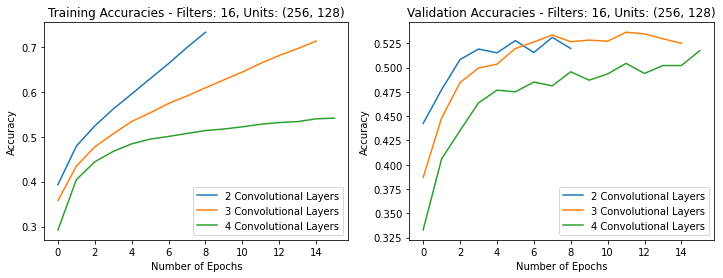

Training 2 layer model - Num Filters: 16, Num Units: (512, 256)
Epoch 1/16
898/898 [==============================] - 4s 5ms/step - loss: 0.2346 - accuracy: 0.4074 - val_loss: 1.4107 - val_accuracy: 0.4703
Epoch 2/16
898/898 [==============================] - 4s 5ms/step - loss: 0.2010 - accuracy: 0.4995 - val_loss: 1.3841 - val_accuracy: 0.4790
Epoch 3/16
898/898 [==============================] - 4s 5ms/step - loss: 0.1812 - accuracy: 0.5516 - val_loss: 1.2969 - val_accuracy: 0.5188
Epoch 4/16
898/898 [==============================] - 4s 4ms/step - loss: 0.1612 - accuracy: 0.6029 - val_loss: 1.3166 - val_accuracy: 0.5280
Epoch 5/16
898/898 [==============================] - 4s 4ms/step - loss: 0.1394 - accuracy: 0.6563 - val_loss: 1.3145 - val_accuracy: 0.5380
Epoch 6/16
898/898 [==============================] - 4s 4ms/step - loss: 0.1150 - accuracy: 0.7166 - val_loss: 1.4308 - val_accuracy: 0.5352
Epoch 7/16
898/898 [==============================] - 4s 4ms/step - loss: 0.0907 - a

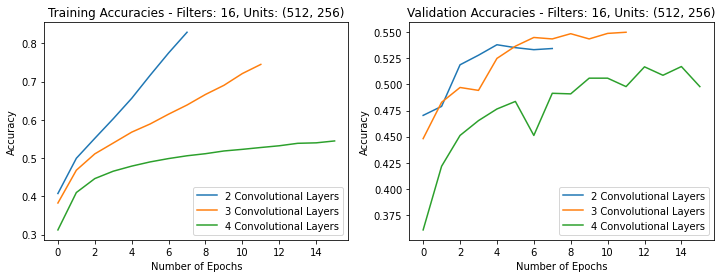

Training 2 layer model - Num Filters: 32, Num Units: (128, 64)
Epoch 1/16
898/898 [==============================] - 5s 5ms/step - loss: 0.2424 - accuracy: 0.3853 - val_loss: 1.4825 - val_accuracy: 0.4266
Epoch 2/16
898/898 [==============================] - 5s 5ms/step - loss: 0.2091 - accuracy: 0.4765 - val_loss: 1.3820 - val_accuracy: 0.4804
Epoch 3/16
898/898 [==============================] - 5s 5ms/step - loss: 0.1948 - accuracy: 0.5155 - val_loss: 1.3147 - val_accuracy: 0.5001
Epoch 4/16
898/898 [==============================] - 5s 5ms/step - loss: 0.1832 - accuracy: 0.5456 - val_loss: 1.3347 - val_accuracy: 0.5127
Epoch 5/16
898/898 [==============================] - 5s 5ms/step - loss: 0.1718 - accuracy: 0.5741 - val_loss: 1.3202 - val_accuracy: 0.5183
Epoch 6/16
898/898 [==============================] - 5s 5ms/step - loss: 0.1612 - accuracy: 0.6029 - val_loss: 1.2789 - val_accuracy: 0.5325
Epoch 7/16
898/898 [==============================] - 5s 5ms/step - loss: 0.1509 - ac

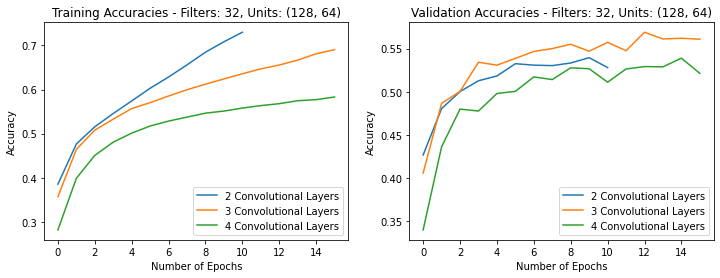

Training 2 layer model - Num Filters: 32, Num Units: (256, 128)
Epoch 1/16
898/898 [==============================] - 5s 6ms/step - loss: 0.2371 - accuracy: 0.4012 - val_loss: 1.4333 - val_accuracy: 0.4508
Epoch 2/16
898/898 [==============================] - 5s 5ms/step - loss: 0.2019 - accuracy: 0.4970 - val_loss: 1.3235 - val_accuracy: 0.5004
Epoch 3/16
898/898 [==============================] - 5s 5ms/step - loss: 0.1835 - accuracy: 0.5428 - val_loss: 1.2750 - val_accuracy: 0.5305
Epoch 4/16
898/898 [==============================] - 5s 5ms/step - loss: 0.1665 - accuracy: 0.5880 - val_loss: 1.2936 - val_accuracy: 0.5194
Epoch 5/16
898/898 [==============================] - 5s 5ms/step - loss: 0.1492 - accuracy: 0.6334 - val_loss: 1.2540 - val_accuracy: 0.5405
Epoch 6/16
898/898 [==============================] - 5s 5ms/step - loss: 0.1309 - accuracy: 0.6786 - val_loss: 1.3714 - val_accuracy: 0.5263
Epoch 7/16
898/898 [==============================] - 5s 5ms/step - loss: 0.1123 - a

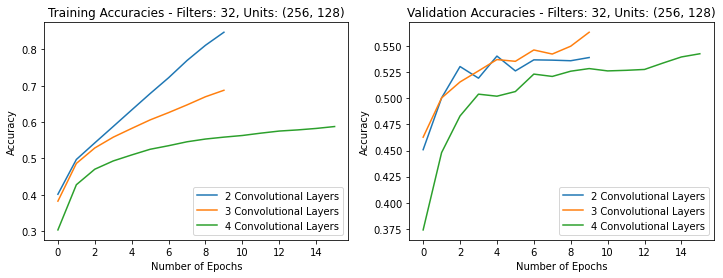

Training 2 layer model - Num Filters: 32, Num Units: (512, 256)
Epoch 1/16
898/898 [==============================] - 5s 6ms/step - loss: 0.2317 - accuracy: 0.4121 - val_loss: 1.3908 - val_accuracy: 0.4648
Epoch 2/16
898/898 [==============================] - 5s 6ms/step - loss: 0.1970 - accuracy: 0.5090 - val_loss: 1.2963 - val_accuracy: 0.5180
Epoch 3/16
898/898 [==============================] - 5s 6ms/step - loss: 0.1751 - accuracy: 0.5655 - val_loss: 1.2531 - val_accuracy: 0.5266
Epoch 4/16
898/898 [==============================] - 5s 6ms/step - loss: 0.1528 - accuracy: 0.6229 - val_loss: 1.2801 - val_accuracy: 0.5450
Epoch 5/16
898/898 [==============================] - 5s 6ms/step - loss: 0.1276 - accuracy: 0.6863 - val_loss: 1.3580 - val_accuracy: 0.5456
Epoch 6/16
898/898 [==============================] - 5s 6ms/step - loss: 0.0991 - accuracy: 0.7569 - val_loss: 1.4905 - val_accuracy: 0.5511
Epoch 7/16
898/898 [==============================] - 5s 6ms/step - loss: 0.0707 - a

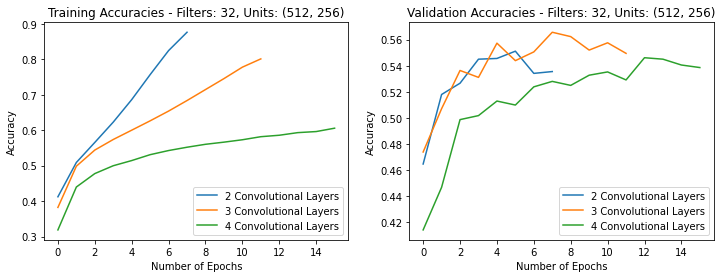

Training 2 layer model - Num Filters: 64, Num Units: (128, 64)
Epoch 1/16
898/898 [==============================] - 7s 8ms/step - loss: 0.2402 - accuracy: 0.3936 - val_loss: 1.5008 - val_accuracy: 0.4358
Epoch 2/16
898/898 [==============================] - 7s 8ms/step - loss: 0.2054 - accuracy: 0.4891 - val_loss: 1.4296 - val_accuracy: 0.4597
Epoch 3/16
898/898 [==============================] - 7s 8ms/step - loss: 0.1890 - accuracy: 0.5306 - val_loss: 1.2956 - val_accuracy: 0.5208
Epoch 4/16
898/898 [==============================] - 7s 8ms/step - loss: 0.1756 - accuracy: 0.5669 - val_loss: 1.2826 - val_accuracy: 0.5135
Epoch 5/16
898/898 [==============================] - 7s 8ms/step - loss: 0.1622 - accuracy: 0.6001 - val_loss: 1.3354 - val_accuracy: 0.5068
Epoch 6/16
898/898 [==============================] - 7s 8ms/step - loss: 0.1499 - accuracy: 0.6321 - val_loss: 1.2868 - val_accuracy: 0.5241
Epoch 7/16
898/898 [==============================] - 7s 8ms/step - loss: 0.1372 - ac

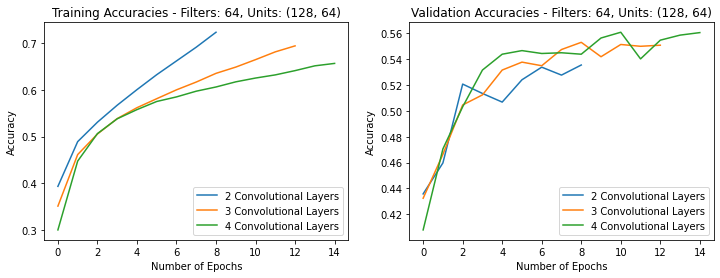

Training 2 layer model - Num Filters: 64, Num Units: (256, 128)
Epoch 1/16
898/898 [==============================] - 7s 8ms/step - loss: 0.2393 - accuracy: 0.3937 - val_loss: 1.4531 - val_accuracy: 0.4489
Epoch 2/16
898/898 [==============================] - 7s 8ms/step - loss: 0.2015 - accuracy: 0.4961 - val_loss: 1.3454 - val_accuracy: 0.4976
Epoch 3/16
898/898 [==============================] - 7s 8ms/step - loss: 0.1821 - accuracy: 0.5471 - val_loss: 1.2741 - val_accuracy: 0.5208
Epoch 4/16
898/898 [==============================] - 7s 8ms/step - loss: 0.1642 - accuracy: 0.5935 - val_loss: 1.2665 - val_accuracy: 0.5319
Epoch 5/16
898/898 [==============================] - 7s 8ms/step - loss: 0.1451 - accuracy: 0.6440 - val_loss: 1.3617 - val_accuracy: 0.5300
Epoch 6/16
898/898 [==============================] - 7s 8ms/step - loss: 0.1256 - accuracy: 0.6904 - val_loss: 1.3464 - val_accuracy: 0.5369
Epoch 7/16
898/898 [==============================] - 7s 8ms/step - loss: 0.1041 - a

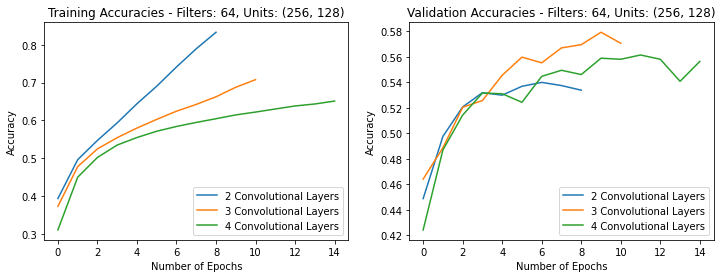

Training 2 layer model - Num Filters: 64, Num Units: (512, 256)
Epoch 1/16
898/898 [==============================] - 8s 9ms/step - loss: 0.2333 - accuracy: 0.4089 - val_loss: 1.3917 - val_accuracy: 0.4675
Epoch 2/16
898/898 [==============================] - 8s 8ms/step - loss: 0.1952 - accuracy: 0.5147 - val_loss: 1.3062 - val_accuracy: 0.5113
Epoch 3/16
898/898 [==============================] - 7s 8ms/step - loss: 0.1724 - accuracy: 0.5743 - val_loss: 1.2648 - val_accuracy: 0.5336
Epoch 4/16
898/898 [==============================] - 7s 8ms/step - loss: 0.1483 - accuracy: 0.6349 - val_loss: 1.2953 - val_accuracy: 0.5403
Epoch 5/16
898/898 [==============================] - 7s 8ms/step - loss: 0.1204 - accuracy: 0.7045 - val_loss: 1.3691 - val_accuracy: 0.5570
Epoch 6/16
898/898 [==============================] - 7s 8ms/step - loss: 0.0905 - accuracy: 0.7767 - val_loss: 1.5594 - val_accuracy: 0.5525
Epoch 7/16
898/898 [==============================] - 7s 8ms/step - loss: 0.0633 - a

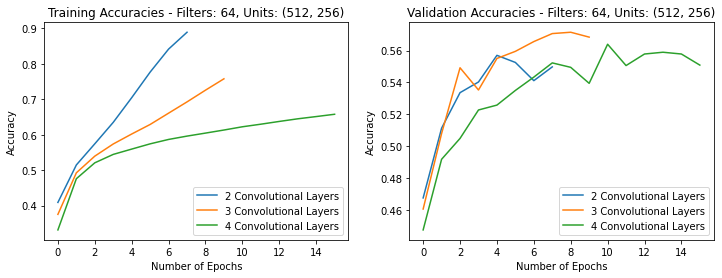

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/My Drive/CS486 Project Data/models/best_simple_CNN/assets
Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_65 (Conv2D)           (None, 46, 46, 64)        640       
_________________________________________________________________
average_pooling2d_22 (Averag (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 21, 21, 64)        36928     
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 10, 10, 64)        0         
_________________________________________

In [18]:
best_model, results_2layer, results_3layer, results_4layer = choose_params(train_images_preprocessed, train_Y, val_images_preprocessed, val_Y, 
                                                               test_images_preprocessed, test_Y, filters_list, units_list, 
                                                               results_2layer, results_3layer, results_4layer)

In [19]:
display(results_2layer)

,"(128, 64)","(256, 128)","(512, 256)"
16,0.516021,0.539426,0.545277
32,0.529953,0.537476,0.542491
64,0.521037,0.533296,0.546113


In [20]:
display(results_3layer)

,"(128, 64)","(256, 128)","(512, 256)"
16,0.534689,0.529395,0.553079
32,0.552243,0.557537,0.564781
64,0.566453,0.569518,0.564503


In [21]:
display(results_4layer)

,"(128, 64)","(256, 128)","(512, 256)"
16,0.502926,0.526052,0.517136
32,0.529953,0.550014,0.545556
64,0.566453,0.569239,0.565896


## Compare Emotion Distributions 

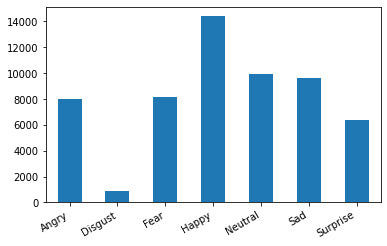

In [22]:
# Training data
train_labels = pd.Series(get_emotion_labels(train_Y)).value_counts().sort_index()
ax = train_labels.plot(kind='bar')
fig = ax.get_figure()
fig.autofmt_xdate()

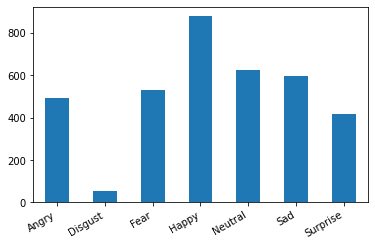

In [23]:
# Test data
test_labels = pd.Series(get_emotion_labels(test_Y)).value_counts().sort_index()
ax = test_labels.plot(kind='bar')
fig = ax.get_figure()
fig.autofmt_xdate()

In [24]:
# Example of loading model
best_model_loaded = load_model(f"{full_project_dir}/models/best_simple_CNN")

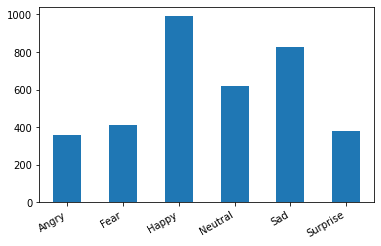

In [25]:
# Predictions
predictions = best_model_loaded.predict(test_images_preprocessed)
test_predictions = pd.Series(get_emotion_labels(predictions)).value_counts().sort_index()
ax = test_predictions.plot(kind='bar')
fig = ax.get_figure()
fig.autofmt_xdate()

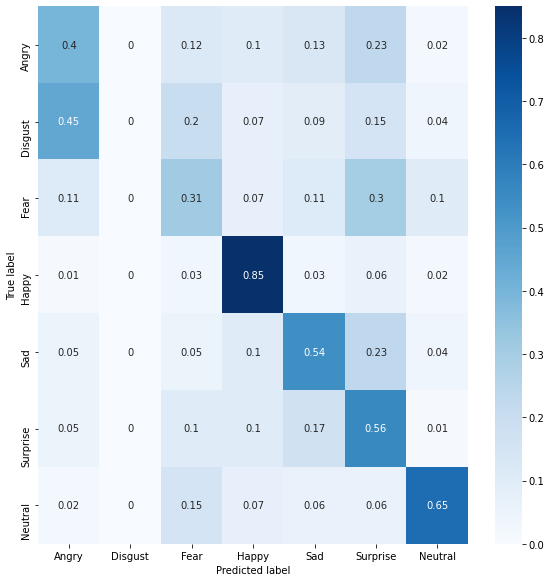

In [29]:
confusion_matrix = sklearn.metrics.confusion_matrix(get_emotion_labels(test_Y), get_emotion_labels(predictions))
confusion_matrix = np.around(confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis], decimals=2)
confusion_matrix = pd.DataFrame(confusion_matrix,
                                index = fer_emotions_dict.values(), 
                                columns = fer_emotions_dict.values())

figure = plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()